# Holmes using USCRN insitu data
We will try to recreate the results from Holmes et. al. by studying the linear relationship between LST and Ka(H) brightness temperature.

We have all stations from the USCRN network LST(lat,lon,time)

* Test Holmes' hypothesis using each station individually.  

* Test it using data from all stations in a given moment in time.  

* Test it using all data from all stations.

$$ HolmesLST(Ka_H) = a * Ka_H + b $$
$$ a = 1.11 $$
$$ b = -15.2 $$


In [9]:
# Libraries
from ismn.interface import ISMN_Interface
import numpy as np
import matplotlib.pyplot as plt 
import xarray as xr
# Custom functions

import sys
sys.path.append("../src")
from processing import load_zip, apply_scaling

# Global
%matplotlib inline

data_path = "../data/raw/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.zip"
selected_network = "USCRN"

ka_path = '../data/raw/ka.zip'

lst = "surface_temperature"

In [2]:
ismn_data = ISMN_Interface(data_path, parallel=True)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


In [3]:
# Get the ids for the USCRN network and subset from the whole dataset
ids = ismn_data.get_dataset_ids(variable='surface_temperature',
                                filter_meta_dict={'network': selected_network}
                                )
uscrn_data = ismn_data.subset_from_ids(ids)

Found existing ismn metadata in ../data/raw/python_metadata/Data_separate_files_header_20170101_20171231_10665_aY1v_20231116.csv.


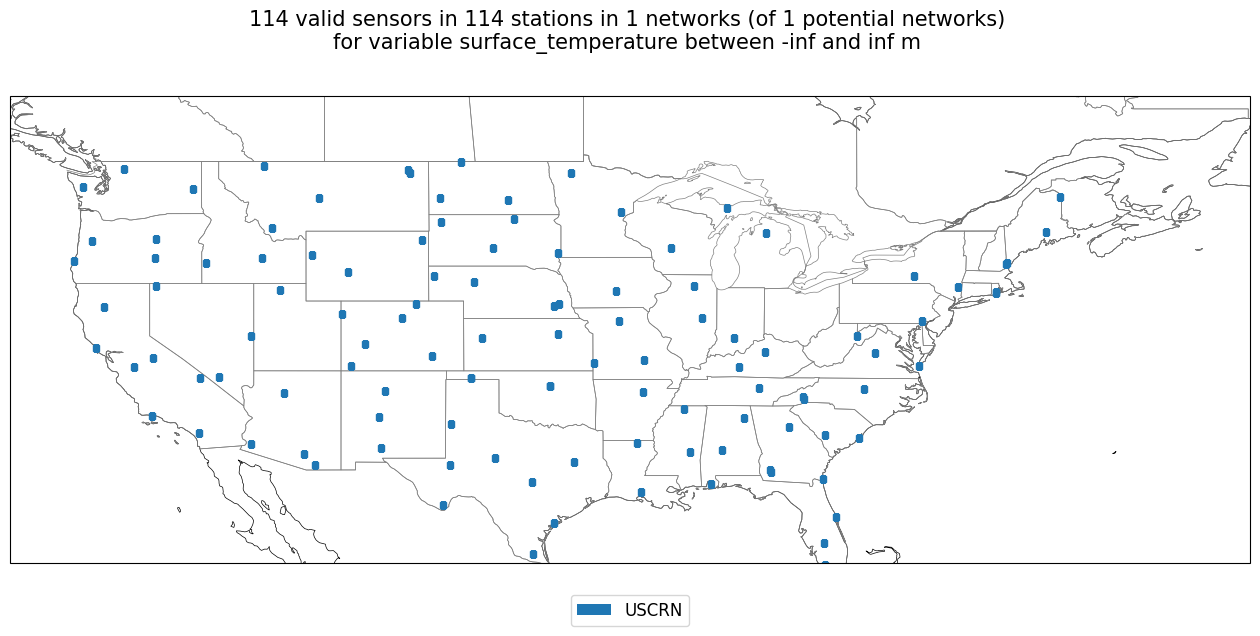

In [4]:
# We can even plot station locations 
import cartopy.crs as ccrs
#plot available station on a map
fig, ax = plt.subplots(1, 1, figsize=(16,10), subplot_kw={'projection': ccrs.PlateCarree()})
uscrn_data.plot_station_locations('surface_temperature', ax=ax, markersize=5, text_scalefactor=3)
ax.set_extent([-128, -57, 26, 47]) # US aproximate coordinate range
plt.show()

In [5]:
# Recover the data only from the sensors that have good timeseries.
ids = uscrn_data.get_dataset_ids("surface_temperature")
valid_sensors = []
for network, station, sensor in uscrn_data.collection.iter_sensors(variable='surface_temperature', depth = [0,0]):
    if np.min(sensor.data["surface_temperature"]) > -100:
        valid_sensors.append((network, station, sensor))
        
len(valid_sensors)

37

In [6]:
# For each sensor, save ascending and descendig passes (6pm and 6am), also lattitude and longitude. save it into a xarray dataset

uscrn_xarray = xr.Dataset()

for network, station, sensor in valid_sensors:
    
    timeseries = uscrn_data[network.name][station.name][sensor.name].data

    ascending_ts = timeseries[timeseries.index.hour == 6]
    descending_ts = timeseries[timeseries.index.hour == 18]

    lon = uscrn_data[network.name][station.name][sensor.name].metadata["longitude"][1]
    lat = uscrn_data[network.name][station.name][sensor.name].metadata["latitude"][1]




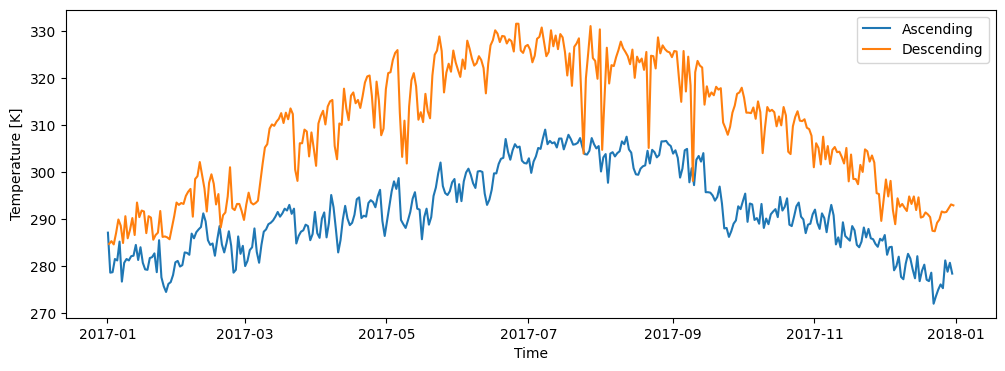

In [7]:
# Use ka band data and get the correlation from a single station (use last from the loop first)
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(ascending_ts["surface_temperature"] + 273.15, label = "Ascending")
ax.plot(descending_ts["surface_temperature"] + 273.15, label = "Descending")
ax.set_ylabel("Temperature [K]")
ax.set_xlabel("Time")
ax.legend()

In [10]:
# retrieve Ka band data:

ka_dataset = load_zip(ka_path)
ka_dataset = apply_scaling(ka_dataset)


Loading zipfile from ../data/raw/ka.zip


100%|██████████| 754/754 [00:18<00:00, 40.80it/s]


Applying scaling


100%|██████████| 3/3 [00:12<00:00,  4.01s/it]


In [12]:
# Select closest pixel to sensor 
node_data = ka_dataset.sel({"lat" : lat, "lon" : lon}, method= "nearest")

In [18]:
ka_ascending = node_data.where(node_data.Pass == "Ascending", drop=True)
ka_descending = node_data.where(node_data.Pass == "Descending", drop=True)

In [38]:
x = ka_descending["Brightness Temperature (H)"][:-1] # We dont have measurements for the last passing for some reason
x.shape

(364,)

In [33]:
y = descending_ts['surface_temperature'].values + 273.15
y.shape

(364,)

(250.0, 350.0)

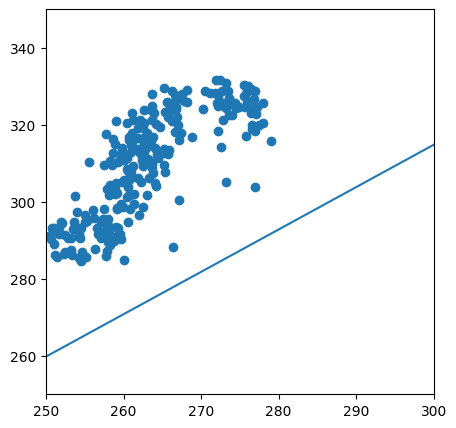

In [47]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x,y)
ax.axline(slope= 1.1, xy1= (0,-15.2)) # Holmes' regression
ax.set_xlim((250,300))
ax.set_ylim((250,350))